In [1]:
# если выдает ошибку с пакетами
# установить пакеты и перезапустить ядро
# TODO: сделать установку окружений

# !pip install scikit-learn --force
# !pip install catboost
# !pip install sktime==0.15.1
# !pip install pandas==1.3.5

In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os
import importlib

pd.set_option('display.max.columns', 300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastConfig
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')


import matplotlib.pyplot as plt

# для записи и чтения экселя
import pip
pip.main(['install', 'openpyxl'])

import openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://nxrm:8081/repository/pypi/simple


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
import pyspark.sql.functions as f

In [1]:
# для записи и чтения экселя
import pip
pip.main(['install', 'openpyxl'])

import openpyxl

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: http://nxrm:8081/repository/pypi/simple

Collecting openpyxl

Downloading http://nxrm:8081/repository/pypi/packages/openpyxl/3.1.5/openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)

Collecting et-xmlfile (from openpyxl)

Downloading http://nxrm:8081/repository/pypi/packages/et-xmlfile/1.1.0/et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)

Installing collected packages: et-xmlfile, openpyxl

Successfully installed et-xmlfile-1.1.0 openpyxl-3.1.5

In [4]:
!pip install pandas
!pip install numpy

Looking in indexes: http://nxrm:8081/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 747.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 907.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastparquet 2024.2.0 requires fsspec, which is not installed.
Looking in indexes: http://nxrm:8081/repository/pypi/simple


In [7]:
!pip install matplotlib

Looking in indexes: http://nxrm:8081/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 748.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 306.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 550.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 313.1 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np

In [9]:
import matplotlib.pyplot as plt

generated new fontManager

## Чтение прогнозов

In [10]:
!pip install pickle

Looking in indexes: http://nxrm:8081/repository/pypi/simple
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [11]:
import pickle


# with open('res_dict.pickle', 'wb') as handle:
#     pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('res_dict.pickle', 'rb') as handle:
    res_dict = pickle.load(handle)


## Загрузка таблиц фактов

In [12]:
# sa_table = spark.table('prod_dadm_alm_sbx.almde_fl_dpst_saving_accounts_monthly_avg_feature')
# sa_table_pd = sa_table.toPandas()
# sa_table_pd.to_csv('./fact_data/sa_fact.csv')

In [13]:
# ca_table = spark.table('prod_dadm_alm_sbx.almde_fl_dpst_current_accounts')
# ca_table_pd = ca_table.toPandas()
# ca_table_pd.to_csv('./fact_data/ca_fact.csv')

In [14]:
sa_table_pd = pd.read_csv('./fact_data/sa_fact.csv')
ca_table_pd = pd.read_csv('./fact_data/ca_fact.csv')

In [15]:
sa_table_pd = sa_table_pd.sort_values(by='report_dt')
ca_table_pd = ca_table_pd.sort_values(by='report_dt')

In [16]:
sa_table_pd.tail()[['report_dt', 'SA_avg_balance_[general]_[mass]', 'SA_avg_balance_[general]_[priv]', 'SA_avg_balance_[general]_[vip]']]

,report_dt,SA_avg_balance_[general]_[mass],SA_avg_balance_[general]_[priv],SA_avg_balance_[general]_[vip]
79,2024-05-31,8.189205e+11,4.094633e+11,8.854591e+10
80,2024-06-30,8.879335e+11,4.483153e+11,1.165230e+11
42,2024-07-31,9.809697e+11,5.166332e+11,1.371393e+11
43,2024-08-31,1.007121e+12,5.599451e+11,1.568668e+11
44,2024-09-30,9.638511e+11,5.616423e+11,1.470692e+11


In [19]:
# sa_table_pd.tail()[['report_dt', 'SA_avg_balance_[general]_[mass]', 'SA_avg_balance_[general]_[priv]', 'SA_avg_balance_[general]_[vip]']].sum(axis=1)

In [20]:
ca_table_pd.tail()

,Unnamed: 0,report_dt,balance_cny_[general],balance_eur_[general],balance_oth_[general],balance_rub_[general],balance_usd_[general],balance_rub_[mass],balance_rub_[priv],balance_rub_[vip],rate_ruonia,VTB_ftp_rate_[90d],VTB_ftp_rate_[730d]
124,124,2024-05-31,3.193282e+08,5.105431e+08,1.154572e+10,6.809284e+11,1.080224e+09,5.109026e+11,1.195101e+11,5.051573e+10,15.947500,17.100000,14.858065
125,125,2024-06-30,3.462774e+08,5.058765e+08,1.105591e+10,7.083955e+11,1.084337e+09,5.346651e+11,1.228598e+11,5.087055e+10,15.651053,17.310000,16.263333
126,126,2024-07-31,3.547077e+08,5.059242e+08,1.214104e+10,7.478071e+11,1.098656e+09,5.729349e+11,1.233124e+11,5.155979e+10,16.113478,18.575806,17.916129
127,127,2024-08-31,3.148768e+08,5.020493e+08,1.184707e+10,8.132118e+11,1.102731e+09,5.974652e+11,1.514463e+11,6.430026e+10,17.743182,19.450000,18.300000
128,128,2024-09-30,2.738400e+08,4.943824e+08,1.211032e+10,8.911279e+11,1.100793e+09,6.307825e+11,1.819677e+11,7.837774e+10,18.390476,20.225000,19.900000


In [37]:
6.307825e+11+1.819677e+11+7.837774e+10

891127940000.0

In [42]:
8.93/ 7.8

1.1448717948717948

#### Сравнение разных вариантов сценариев

In [ ]:
delta1 = (res_dict['parse_sc_v2_r21']['scenario'] - res_dict['parse_sc_v1_r21']['scenario']).T

In [ ]:
delta1[(delta1!=0).all(axis=1)]

* Трансферты выросли на 1%  
* основной рост без опций - в срочностях 90 и 365  
* основной рост с пополнением без снятий - 90 и 180  
* основной рост с пополнением и снятиями - 90 и 180  
* __у второго варианта сценариев ставки выше__ 

In [ ]:
delta2 = (res_dict['parse_sc_v2_r22']['scenario'] - res_dict['parse_sc_v1_r22']['scenario']).T

In [ ]:
delta2[(delta2!=0).all(axis=1)]

* Трансферты выросли на 1%  
* основной рост без опций - в срочностях 90, 185 и 365. В основном на 180 - 2%    
* __у второго варианта сценариев ставки выше__ 

#### Ниже - дельты по новым сценариям

In [ ]:
delta3 = (res_dict['parse_sc_v2_r22']['scenario'] - res_dict['parse_sc_v2_r21']['scenario']).T
delta3[(delta1!=0).all(axis=1)]

* Трансфертные ставки поднялись на 1% равномерно  
* Увеличились срочности до года для всех сегментов без опций: 90, 180 и 365. Наибольший рост - на 1.8% на 180 дней

#### Идея - отранжировать по величине ставки

In [28]:
# порядок по увеличению ставок

sc_names_soreted_rates = ['parse_sc_v1_r20', 
                          'parse_sc_v1_r21',
                          'parse_sc_v2_r21',
                          'parse_sc_v1_r22',
                          'parse_sc_v2_r22'
                         ]

## Анализ прогнозов

Потом можно откорректировать через досрочку

In [34]:
for sc in sc_names_soreted_rates:
    
    res_dict[sc]['CurrentAccounts']['report_dt'] = res_dict['parse_sc_v1_r20']['SavingAccounts'].report_dt
    print(sc, res_dict[sc]['scenario']['rate_sa_weighted'][0])

parse_sc_v1_r20 16
parse_sc_v1_r21 17
parse_sc_v2_r21 17
parse_sc_v1_r22 17.5
parse_sc_v2_r22 17.5


## Накопительные счета

In [35]:
res_dict['parse_sc_v1_r20']['CurrentAccounts']

,segment,balance,report_dt
0,mass,5.775644e+11,2024-10-31
1,mass,6.171956e+11,2024-11-30
2,mass,6.440214e+11,2024-12-31
3,priv,1.452163e+11,2024-10-31
4,priv,1.551807e+11,2024-11-30
5,priv,1.619255e+11,2024-12-31
6,vip,6.170528e+10,2024-10-31
7,vip,6.593937e+10,2024-11-30
8,vip,6.880536e+10,2024-12-31


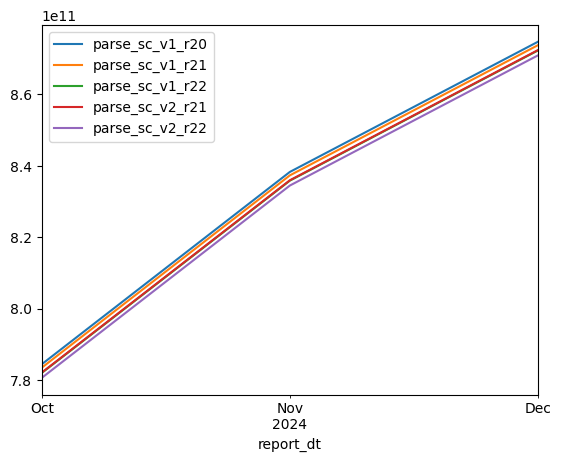

In [36]:
res_dict['parse_sc_v1_r20']['CurrentAccounts'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r20')
res_dict['parse_sc_v1_r21']['CurrentAccounts'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r21')
res_dict['parse_sc_v1_r22']['CurrentAccounts'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r22')

res_dict['parse_sc_v2_r21']['CurrentAccounts'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r21')
res_dict['parse_sc_v2_r22']['CurrentAccounts'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r22')

plt.legend()

Отрабатывает корректно потому что всокие ставки по депозитам начинаются позже

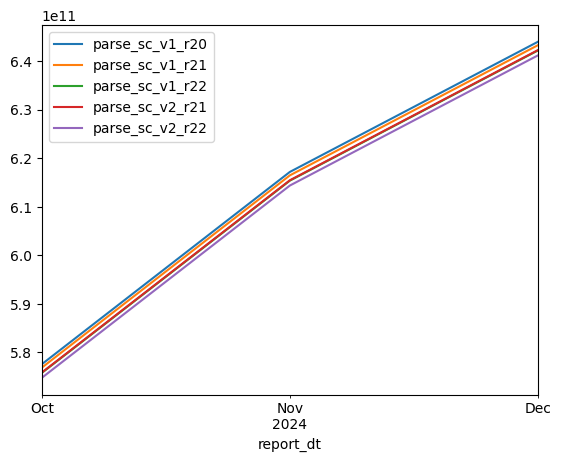

In [38]:
segm = 'mass'

res_dict['parse_sc_v1_r20']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r20')
res_dict['parse_sc_v1_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r21')
res_dict['parse_sc_v1_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r22')

res_dict['parse_sc_v2_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r21')
res_dict['parse_sc_v2_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r22')

plt.legend()

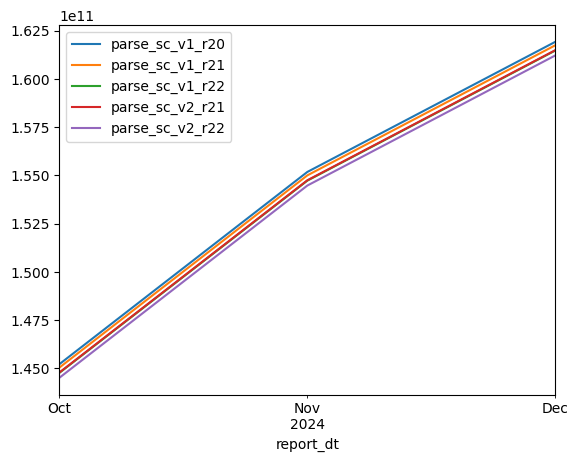

In [39]:
segm = 'priv'

res_dict['parse_sc_v1_r20']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r20')
res_dict['parse_sc_v1_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r21')
res_dict['parse_sc_v1_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r22')

res_dict['parse_sc_v2_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r21')
res_dict['parse_sc_v2_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r22')

plt.legend()

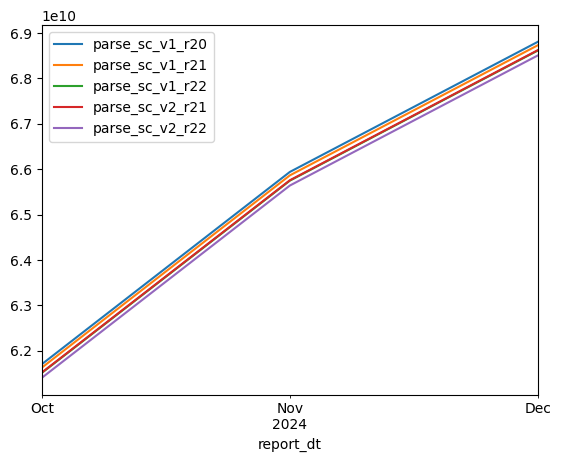

In [40]:
segm = 'vip'

res_dict['parse_sc_v1_r20']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r20')
res_dict['parse_sc_v1_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r21')
res_dict['parse_sc_v1_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r22')

res_dict['parse_sc_v2_r21']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r21')
res_dict['parse_sc_v2_r22']['CurrentAccounts'].query(f'segment=="{segm}"').groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r22')

plt.legend()

## Фиксим

In [41]:
sc_names_soreted_rates

['parse_sc_v1_r20',
 'parse_sc_v1_r21',
 'parse_sc_v2_r21',
 'parse_sc_v1_r22',
 'parse_sc_v2_r22']

In [43]:
res_dict_agg_fix = {}

for sc_name in sc_names_soreted_rates:
    tmp1 = res_dict[sc_name]['CurrentAccounts'].copy()
    
    tmp1['balance']  = tmp1['balance'] * 1.15
    
    res_dict_agg_fix[sc_name] = tmp1

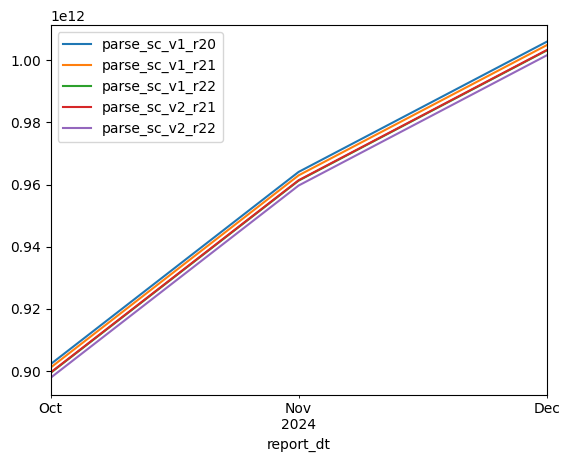

In [44]:
res_dict_agg_fix['parse_sc_v1_r20'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r20')
res_dict_agg_fix['parse_sc_v1_r21'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r21')
res_dict_agg_fix['parse_sc_v1_r22'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v1_r22')

res_dict_agg_fix['parse_sc_v2_r21'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r21')
res_dict_agg_fix['parse_sc_v2_r22'].groupby('report_dt').sum()['balance'].plot(label='parse_sc_v2_r22')

plt.legend()

Трансферты у 2-го варианта выше

## Тестирование прогнозов и сверка с фактом

In [ ]:
fact_data = pd.read_csv('./fact_data/dpst_table_gr_pd.csv', index_col='Unnamed: 0')

In [ ]:
df_fact = pd.DataFrame(fact_data.groupby('report_dt').sum()['balance']).reset_index()

In [ ]:
df_fact.tail(10)

In [ ]:
mass = fact_data[fact_data.is_vip_or_prv==0].sort_values(by='report_dt')
priv = fact_data[fact_data.is_vip_or_prv==1].sort_values(by='report_dt')
vip = fact_data[fact_data.is_vip_or_prv==2].sort_values(by='report_dt')

In [ ]:
mass.tail(10)

In [ ]:
priv.tail(10)

In [ ]:
vip.tail(10)

In [ ]:
import plotly.express as px

fig = px.line(df_fact, x="report_dt", y="balance", title='fact balance')
fig.show()

### Анализ нового бизнеса

In [ ]:
nb_data = pd.read_csv('./fact_data/nb_fact_pd.csv', index_col='Unnamed: 0')

In [ ]:
nb_data.tail(10)

## Сохранение прогнозов

In [39]:
# res_dict_agg_fix

In [ ]:
sc_names_soreted_rates

In [40]:
# для записи и чтения экселя
import pip
pip.main(['install', 'openpyxl'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://nxrm:8081/repository/pypi/simple


0

In [41]:
import openpyxl

In [45]:
for sc_name in sc_names_soreted_rates:

    with pd.ExcelWriter(f"./results/ca_{sc_name[-9:]}.xlsx") as writer:
        res_dict[sc_name]['scenario'].to_excel(writer, sheet_name='scenario_'+sc_name[-9:], index=False)
        res_dict_agg_fix[sc_name].to_excel(writer, sheet_name='CA_'+sc_name[-9:], index=False)